In [1]:
import math 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima, ADFTest
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from mutil import *


# Cargar los datasets

Most common crime:  Agresión-Persona


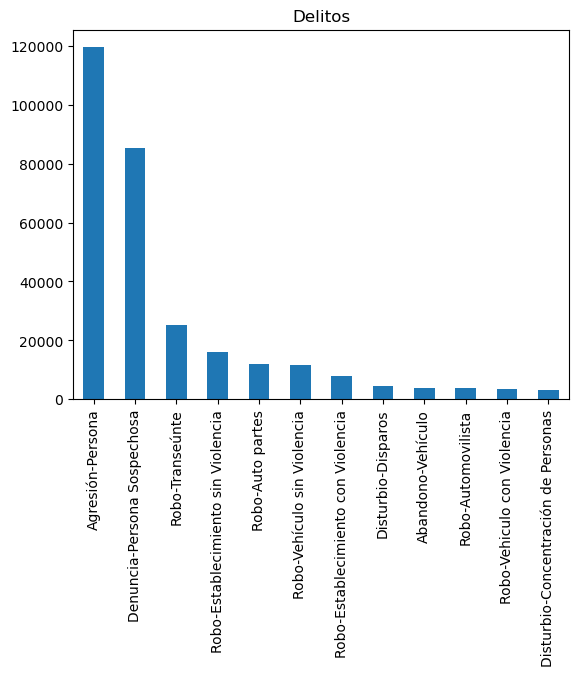

In [10]:
df_delitos, df_camaras = load_data()
df_delitos = preprocess_data(df_delitos, df_camaras)

#find out the most common crime
delitos = df_delitos['incidente_c4'].value_counts().sort_values(ascending=False)
# get the most common crime
delito = delitos.index[0]
most_common_crime = delito
print('Most common crime: ', most_common_crime)
delitos.plot(kind='bar', title='Delitos')
plt.show()

# Filter df_delitos by most common crime
df_delitos = df_delitos[df_delitos['incidente_c4'] == most_common_crime]
# Filter df_delitos by sector_inicio ONLY ROMA
df_delitos = df_delitos[df_delitos['sector_inicio']=='ROMA']
columns = list(df_delitos.columns)
# Drop columns called [latitud, longitud, folio, incidente_c4]from columns
columns = [x for x in columns if x not in ['latitud', 'longitud', 'folio', 'incidente_c4', 'colonia', 'sector_inicio']]

# Set 00 the minutes and second from the hour in the column fecha_creacion and convert to datetime
df_delitos['fecha_creacion'] = df_delitos['fecha_creacion'].dt.strftime('%Y-%m-%d %H:00:00')
df_delitos['fecha_creacion'] = pd.to_datetime(df_delitos['fecha_creacion'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df_delitos = df_delitos.groupby('id_camara')
df_delitos.head()

,folio,fecha_creacion,incidente_c4,colonia,delegacion_inicio,sector_inicio,latitud,longitud,id_camara
1692,C5/20220828/00779,2022-08-28 01:00:00,Agresión-Persona,TACUBAYA,MIGUEL HIDALGO,ROMA,19.407909,-99.184035,69
2594,C5/20221201/01367,2022-12-01 10:00:00,Agresión-Persona,CENTRO URBANO BENITO JUAREZ,CUAUHTEMOC,ROMA,19.407501,-99.159985,137
2595,C5/20221211/05281,2022-12-11 18:00:00,Agresión-Persona,ROMA SUR,CUAUHTEMOC,ROMA,19.408001,-99.160093,137
2600,C5/20220206/02185,2022-02-06 09:00:00,Agresión-Persona,ROMA SUR,CUAUHTEMOC,ROMA,19.407188,-99.159905,137
2606,C5/20220503/01686,2022-05-03 12:00:00,Agresión-Persona,CENTRO URBANO BENITO JUAREZ,CUAUHTEMOC,ROMA,19.408623,-99.159948,137
...,...,...,...,...,...,...,...,...,...
295526,C5/20220806/00498,2022-08-06 01:00:00,Agresión-Persona,CONDESA,CUAUHTEMOC,ROMA,19.410452,-99.180412,MC17805
295528,C5/20220830/00986,2022-08-30 09:00:00,Agresión-Persona,HIPODROMO CONDESA,CUAUHTEMOC,ROMA,19.410690,-99.180770,MC17805
295531,C5/20220114/01559,2022-01-14 13:00:00,Agresión-Persona,HIPODROMO CONDESA,CUAUHTEMOC,ROMA,19.410759,-99.180952,MC17805
295532,C5/20220216/00768,2022-02-16 09:00:00,Agresión-Persona,HIPODROMO CONDESA,CUAUHTEMOC,ROMA,19.410759,-99.180952,MC17805


In [14]:
# Análisis estádistico utilizando auto ARIMA

# save the minumum error and best error 
min_value = math.inf
max_value = -math.inf
dayofweek = {0: 'lunes', 1: 'martes', 2: 'miércoles', 3: 'jueves', 4: 'viernes', 5: 'sábado', 6: 'domingo'}

# Start timer to measure the time of execution
start = time.time()
start_day = start
end_day = start
start_camara = start
end_camara = start

# Iteration for each hour and day of the week
for day in range(0, 7):
    # dictionary with the day of the week in spanish
    # day name in spanish
    day_name = dayofweek[day]
    # Save next results where there is data for the day of the week in a excel called 'consigas_[dayofweek].csv' with the columns: STV:id_camara, hora:hour_start:00-hour_start:59, dia:dayofweek
    # create a dataframe with the columns: STV:id_camara, hora:hour_start:00-hour_start:59, dia:dayofweek
    df_delitos_count_day = pd.DataFrame(columns=['STV', 'hora', 'dia'])
    # Start time for each day of the week
    start_day = time.time()
    i = 0
    for hour in range(0, 24):
        for id_camara, df in df_delitos:
            i += 1
            print(f'\rProcessing {i}/{len(df_delitos.groups)} ID:{id_camara} {day_name}->{hour}:00 [{round((end_day - start_day), 2)}s per day] || [{round((end_camara - start_camara), 2)}s per camera] || [{round((end_camara - start), 2)}s total by now]', end='')
            # Start time for each camera
            start_camara = time.time()
            # print(f'Processing {i}/{len(df_delitos.groups)} ID:{id_camara}...')
            # Count the number of crimes per day but saving the date and the id_camara and set the fecha_creacion as index
            df_delitos_count = df.groupby(columns).size().reset_index(name='count')
            #print(df_delitos_count.head())
            # Create rows for all the hours in the year 2022 and 2023 without losing the existing data
            df_delitos_count = df_delitos_count.set_index('fecha_creacion').reindex(pd.date_range(start='2022-01-01', end='2023-02-01', freq='H')).reset_index().rename(columns={'index': 'fecha_creacion'})
            # Find not nat values
            df_delitos_count.fillna(0, inplace=True)
            # Split the data into train (last 3 months in 2022) and test (first 2 weeks in 2023)
            # DONT USE 'train = df_delitos_count[df_delitos_count.fecha_creacion.dt.year == 2022 and df_delitos_count.fecha_creacion.dt.month >= 10]' IS AMBIGUOUS
            train = df_delitos_count[(df_delitos_count.fecha_creacion.dt.year == 2022) | (df_delitos_count.fecha_creacion.dt.isocalendar().week >= 52)]
            test = df_delitos_count[(df_delitos_count.fecha_creacion.dt.year == 2023) & (df_delitos_count.fecha_creacion.dt.isocalendar().week == 1)]
            # Hacer autoarima como en la seccion de abajo para todos los lunes a las 00:00, despues todos los lunes a las 01:00, etc
            # Filter the data for the hour and day of the week
            train_hour = train[(train.fecha_creacion.dt.hour == hour) & (train.fecha_creacion.dt.dayofweek == day)]
            test_hour = test[(test.fecha_creacion.dt.hour == hour) & (test.fecha_creacion.dt.dayofweek == day)]
            # If there is no data for the hour and day of the week, continue
            if len(train_hour) == 0 or len(test_hour) == 0:
                continue
            # Fit the model            
            model = auto_arima(train['count'], stationary=True, 
                                    test='adf', start_p=1, d=1, start_q=0,
                                    max_p=7, max_d=7, max_q=7,
                                    # daily data 
                                    m=0,
                                    # Desactivar el test
                                    # seasonal=False,
                                    seasonal=False,
                                    seasonal_test='ch', start_P=0, D=0, start_Q=0,
                                    trace=False, stepwise=True,
                                    suppress_warnings=True, error_action='ignore',
                                    random_state=0)
            # Forecast
            forecast, confint = model.predict(n_periods=len(test_hour), return_conf_int=True)
            # day as string name
            # Save the results from the forecast
            df_delitos_count_day = pd.concat([df_delitos_count_day, pd.DataFrame({'STV': id_camara, 'hora': f'{hour}:00-{hour}:59', 'dia': day_name, 'cantidad': forecast})], ignore_index=True)
            # End time for each camera
            end_camara = time.time()
    # Round values to 0 if they are less than 0.30 to floor else ceil
    df_delitos_count_day['cantidad'] = df_delitos_count_day['cantidad'].apply(lambda x: math.floor(x) if x < 0.30 else math.ceil(x))
    #Drop rows tih cantidad = 0
    df_delitos_count_day = df_delitos_count_day[df_delitos_count_day['cantidad'] != 0]
    # Order the columns by dia, hora and STV
    df_delitos_count_day.sort_values(by=['dia', 'hora', 'STV'], inplace=True)
    # Save the results from the forecast
    df_delitos_count_day.to_csv(f'consigas_{day_name}.csv', index=False)
    # End time for each day of the week
    end_day = time.time()

# Stop timer to measure the time of execution
end = time.time()
print(f'Execution time: {end - start} seconds per week')


Processing 2/459 ID:10014 lunes>0:00...

KeyboardInterrupt: 

In [ ]:
# Análisis estádistico utilizando ARIMA

# To install statsmodels use conda install -c conda-forge statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# To install pmdarima use conda install -c conda-forge pmdarima
from pmdarima import auto_arima 

df_by_delitos = df.groupby('incidente_c4')

for delito, delito_df in df_by_delitos:
    print('delito', delito)

    delito_df_pt = delito_df.groupby('fecha_creacion').count()#['incidente_c4'].to_frame()
    delito_df_pt.rename(columns={'incidente_c4':'obs'}, inplace=True)
    delito_arima_df = delito_df_pt[['obs']]
    print('delito_df_pt', delito_arima_df)
    #print('columns', delito_df_pt.columns)

    #find if one day is missing and print it
    for i in range(len(delito_arima_df)-1):
        if delito_arima_df.index[i+1] - delito_arima_df.index[i] != pd.Timedelta(days=1):
            print('Missing day', delito_arima_df.index[i+1])
            # add missing day
            
            delito_arima_df.loc[delito_arima_df.index[i+1]] = 0
    
    # Create time series and plot
    RT = delito_arima_df.iloc[-678:].astype(float).squeeze().to_numpy()
    RT = pd.Series(RT, index=pd.date_range(start='2022-01-01', end='2022-12-31', freq='D'))
    plt.plot(RT)

In [ ]:
# To install statsmodels use conda install -c conda-forge statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# To install pmdarima use conda install -c conda-forge pmdarima
from pmdarima import auto_arima 

# Read RDS file
echoT = pd.read_pickle("C:/Users/lpenac/Documents/SUPERBASES/echo_TOTAL.Rds")

# Filter and group data
RoboTranseunte = (
    echoT.loc[echoT['incidente_c4'] == 'Robo-Transeúnte']
        .groupby(['fecha_cierre', 'incidente_c4'])
        .count()
        .reset_index()
        .drop('incidente_c4', axis=1)
)

# Create date range and join with grouped data
date_range = pd.DataFrame({'fecha_cierre': pd.date_range(start='2021-01-01', end='2023-01-30', freq='D')})
Rob = pd.merge(date_range, RoboTranseunte, on='fecha_cierre', how='left')
Rob.fillna(0, inplace=True)
Rob.rename(columns={'n': 'obs'}, inplace=True)
Rob = Rob.drop('fecha_cierre', axis=1)

# Create time series and plot
RT = Rob.iloc[-678:].astype(float).squeeze().to_numpy()
RT = pd.Series(RT, index=pd.date_range(start='2021-03-01', end='2023-01-30', freq='D'))
plt.plot(RT)

# ADF test
result = adfuller(RT)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Plot ACF and PACF
plot_acf(RT, lags=365)
plot_pacf(RT, lags=365)

# Model 1
model1 = ARIMA(RT, order=(1, 0, 1))
model1 = model1.fit()
print(model1.summary())
residuals = model1.resid

# Model 2
model2 = ARIMA(RT, order=(7, 0, 7))
model2 = model2.fit()
print(model2.summary())
residuals = model2.resid

# Forecast with Model 2
forecast = model2.forecast(steps=5)
print(forecast)

# Auto ARIMA
auto = auto_arima(RT, seasonal=False, suppress_warnings=True)
print(auto.summary())

# Model 3
model3 = ARIMA(RT, order=auto.order)
model3 = model3.fit()
print(model3.summary())
residuals = model3
